In [5]:
import pandas as pd
import numpy as np
import re
import os
import plotnine
from plotnine import *
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import figure

pd.set_option('display.max_columns', None)

In [6]:
col_to_open = ['caseid', 
        "gender", "gender_post",
        "birthyr", "birthyr_post",
        'educ', "race", "hispanic",
        "pid3",
        "votereg", "votereg_post", 
        "inputstate", "region", 
        "CC20_330a", "CC20_330b", "CC20_330c",
        "CC20_331a", "CC20_331b", "CC20_331c", "CC20_331d", "CC20_331e", 
         "presvote16post", 
         "CC20_363", 
         "CC20_364b"]

In [7]:
election = pd.read_csv('cces_2020.csv', header=0, usecols = col_to_open)

In [8]:
election.head()

,caseid,birthyr,gender,educ,race,hispanic,inputstate,votereg,region,CC20_330a,CC20_330b,CC20_330c,CC20_331a,CC20_331b,CC20_331c,CC20_331d,CC20_331e,CC20_363,CC20_364b,presvote16post,pid3,votereg_post,birthyr_post,gender_post
0,1232318697,1966,1,4,1,2.0,9,1,1,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,NaN,2.0,2,1.0,1966.0,1.0
1,1231394915,1955,2,6,1,2.0,12,2,3,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,5.0,2.0,7.0,1,2.0,1955.0,2.0
2,1232451503,1946,2,5,1,2.0,19,1,2,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,7.0,3,1.0,1946.0,2.0
3,1232494791,1962,2,5,1,2.0,25,1,1,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1,1.0,1962.0,2.0
4,1232494829,1967,1,5,1,2.0,17,1,2,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,3.0,3,1.0,1967.0,1.0


In [9]:
#voter registration: 1=Yes, registered to vote; 2=no, not registered; 3=don't know

election.value_counts(["votereg"], normalize=True)

votereg
1          0.888082
2          0.096246
3          0.015672
Name: proportion, dtype: float64

In [10]:
#registered voter breakdwon

gender_map = {1: "Male", 2: "Female"}

race_map = {1: "White", 2: "Black/AfAm", 3: "Latino/Hispanic", 4: "Asian", 5: "Native American", 6: "Two or More Race",
           7: "Other", 8: "Middle Eastern"}

party_map = {1: "Democrat", 2: "Republican", 3: "Independent", 4: "Other", 5: "Not Sure"}

election_registered_voters = election[election["votereg"] == 1].replace({"gender": gender_map, "race": race_map, "pid3": party_map})



#gender breakdown
print(election_registered_voters.value_counts(["gender"], normalize = True))

#racial breakdown
print(election_registered_voters.value_counts(["race"], normalize = True))

#party breakdown
print(election_registered_voters.value_counts(["pid3"], normalize = True))


gender
Female    0.564488
Male      0.435512
Name: proportion, dtype: float64
race            
White               0.736437
Black/AfAm          0.112270
Latino/Hispanic     0.077732
Asian               0.026803
Two or More Race    0.021247
Other               0.016816
Native American     0.007439
Middle Eastern      0.001255
Name: proportion, dtype: float64
pid3       
Democrat       0.396711
Independent    0.276134
Republican     0.260591
Other          0.039558
Not Sure       0.027006
Name: proportion, dtype: float64


In [11]:
#gender variable: 1=male, 2=female

#registered voters in male and female population

election_gender = election.filter(["caseid", "gender", "votereg"]).rename(columns ={"caseid":"count"})

eg = election_gender.groupby(["gender", "votereg"], as_index = False).count()

eg_sum = eg.groupby(["gender"], as_index = False)["count"].transform('sum')

eg["proportion"] = eg['count'].div(eg_sum)


eg_voters = eg[eg["votereg"] == 1].reset_index(drop = True).replace({"gender": gender_map})

print(eg_voters)

   gender  votereg  count  proportion
0    Male        1  23593    0.914776
1  Female        1  30580    0.868528


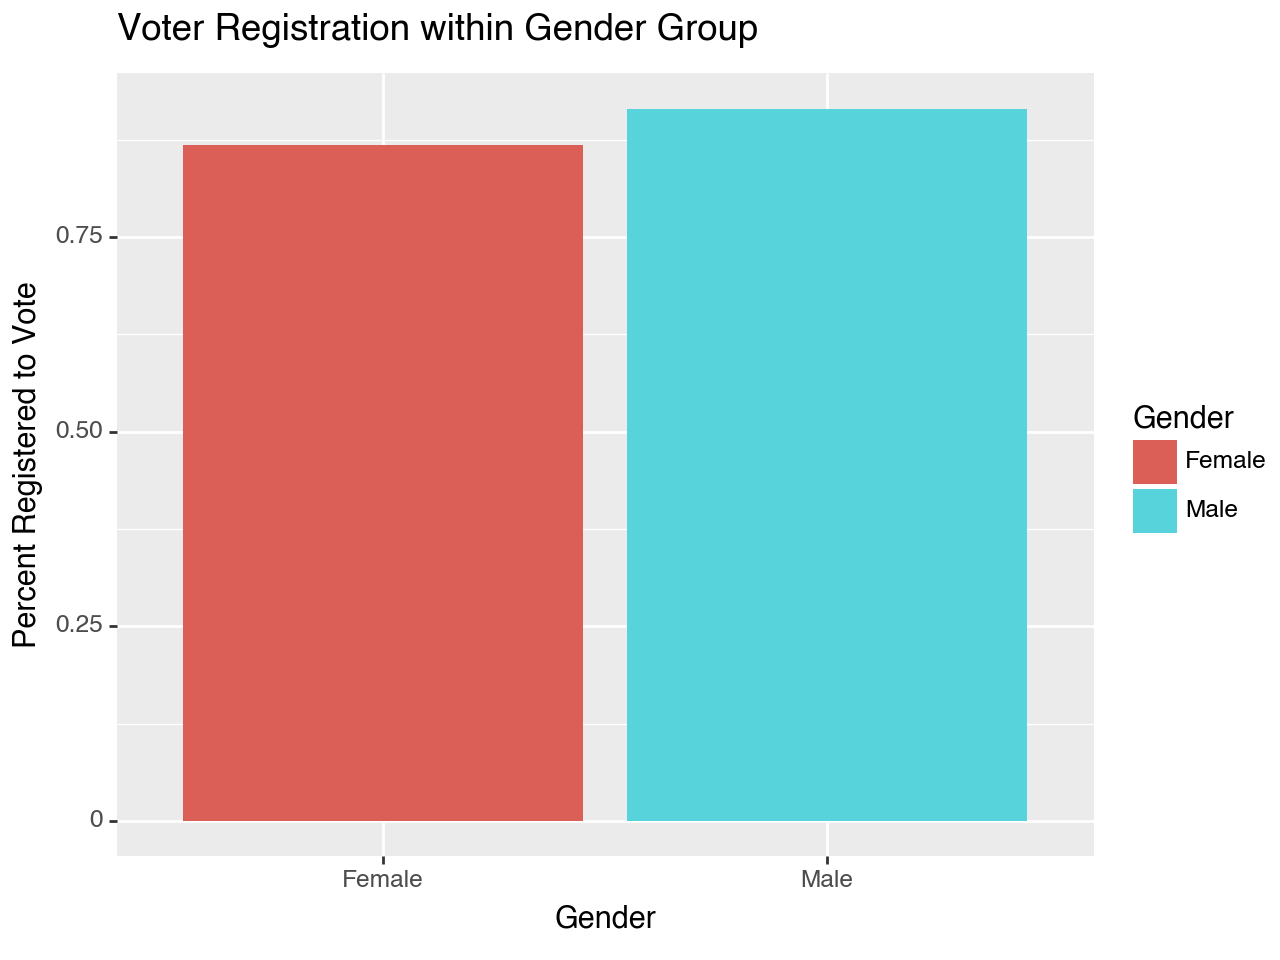

/Users/katharynloweth/anaconda3/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/katharynloweth/anaconda3/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig1_voter_registration_gender_breakdown.pdf


In [12]:
gender_plot = (ggplot(eg_voters) 
 + aes(x= "gender", y= "proportion", fill = "gender") 
 + geom_col()
 + labs(x = "Gender", y = "Percent Registered to Vote", title = "Voter Registration within Gender Group")
 + scale_fill_hue(name = "Gender"))



print(gender_plot)

ggsave(gender_plot, filename = "fig1_voter_registration_gender_breakdown.pdf")

In [13]:
rename_dict = {}

def rename_columns(dataset, columnlist, strreplace):
    """
    Returns inputed dataset, but the names of the columns in input 'columnlist' have been changed based on the
    input "strreplace"
    
    Inputs:
    dataset: data type - pandas dataframe
    columnlist: data type - list
    strreplace: data type - string
    
    Function creates a dictionary using the identified columns in columnlist as the keys. Creates the value for
    these keys using strreplace. Keeps the last character in the original column name to help differentiate the columns.
    Then function uses the dictionary to reassign the column names in the inputed dataset.
   
    """
    for i in range(len(columnlist)):
        col = columnlist[i]
        col_last_char = col[-1]
        newname = strreplace + "_" + col_last_char
        rename_dict[col] = newname
    dataset.rename(columns=rename_dict, inplace=True)

    
rename_columns(election, ["CC20_330a", "CC20_330b", "CC20_330c"], "gun_control")

print(list(election.columns))

['caseid', 'birthyr', 'gender', 'educ', 'race', 'hispanic', 'inputstate', 'votereg', 'region', 'gun_control_a', 'gun_control_b', 'gun_control_c', 'CC20_331a', 'CC20_331b', 'CC20_331c', 'CC20_331d', 'CC20_331e', 'CC20_363', 'CC20_364b', 'presvote16post', 'pid3', 'votereg_post', 'birthyr_post', 'gender_post']


In [14]:
#flipping scale of some variables so that they answers choices are on same scale

flipped_scale = {1.0: 2.0, 2.0: 1.0}

print(election["gun_control_b"].head()) #printing original column values to see if the function works 

def flipping_scale(dataset, variable_name):
    """
    Function reverses the answer choices for the inputed variable in the inputed dataset.
    Uses the dictionary "flipped_scale" to replace values in the inputed variable. 

    Inputs:
    Dataset: data type - pandas dataframe
    variable_name: data type - string
    
    """
    dataset.replace({variable_name: flipped_scale}, inplace = True)
    
        
flipping_scale(election, "gun_control_b")

print(election["gun_control_b"].head())

0    1.0
1    1.0
2    1.0
3    1.0
4    2.0
Name: gun_control_b, dtype: float64
0    2.0
1    2.0
2    2.0
3    2.0
4    1.0
Name: gun_control_b, dtype: float64


In [15]:
election["gun_control_overall"] = election.apply(lambda x: x["gun_control_a"] + x["gun_control_b"] + x["gun_control_c"], axis = 1)
election.head()

,caseid,birthyr,gender,educ,race,hispanic,inputstate,votereg,region,gun_control_a,gun_control_b,gun_control_c,CC20_331a,CC20_331b,CC20_331c,CC20_331d,CC20_331e,CC20_363,CC20_364b,presvote16post,pid3,votereg_post,birthyr_post,gender_post,gun_control_overall
0,1232318697,1966,1,4,1,2.0,9,1,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,NaN,2.0,2,1.0,1966.0,1.0,5.0
1,1231394915,1955,2,6,1,2.0,12,2,3,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,5.0,2.0,7.0,1,2.0,1955.0,2.0,6.0
2,1232451503,1946,2,5,1,2.0,19,1,2,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,7.0,3,1.0,1946.0,2.0,5.0
3,1232494791,1962,2,5,1,2.0,25,1,1,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1,1.0,1962.0,2.0,6.0
4,1232494829,1967,1,5,1,2.0,17,1,2,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,3.0,3,1.0,1967.0,1.0,3.0


In [16]:
input_column = "gun_control_overall"

def build_index(dataset, column):
    """
    Returns an appended column in the inputed dataset that provides a normalized value for the inputed column
    
    Function creates a new column name based on the inputed column string and adds the words "index".
    
    For each row in the dataset, function calculates the index value by subtracting the mean value
    from the individual value and dividing the difference by the standard deviation value
    
    Function also prints the mean and standard deviation of the values in in the inputed column as a way to help 
    check that the values are correct.
    
    Inputs:
    Dataset: data type - pandas dataframe
    Column: data type - string
    
    """
    colsplit = column.split("_")
    index_col = colsplit[0] + "_" + colsplit[1] + "_" + "index"
    meancol = dataset[column].mean()
    stdcol = dataset[column].std()
    print("the mean of", column, "variable is", meancol, "; the std.dev of", column, "variable is", stdcol) 
    dataset[index_col] = (dataset[column] - meancol) / stdcol


build_index(election, input_column)
print(election.filter(["gun_control_overall", "gun_control_index"]).head(3))

the mean of gun_control_overall variable is 4.746670165999606 ; the std.dev of gun_control_overall variable is 1.1057139995083656
   gun_control_overall  gun_control_index
0                  5.0           0.229110
1                  6.0           1.133503
2                  5.0           0.229110


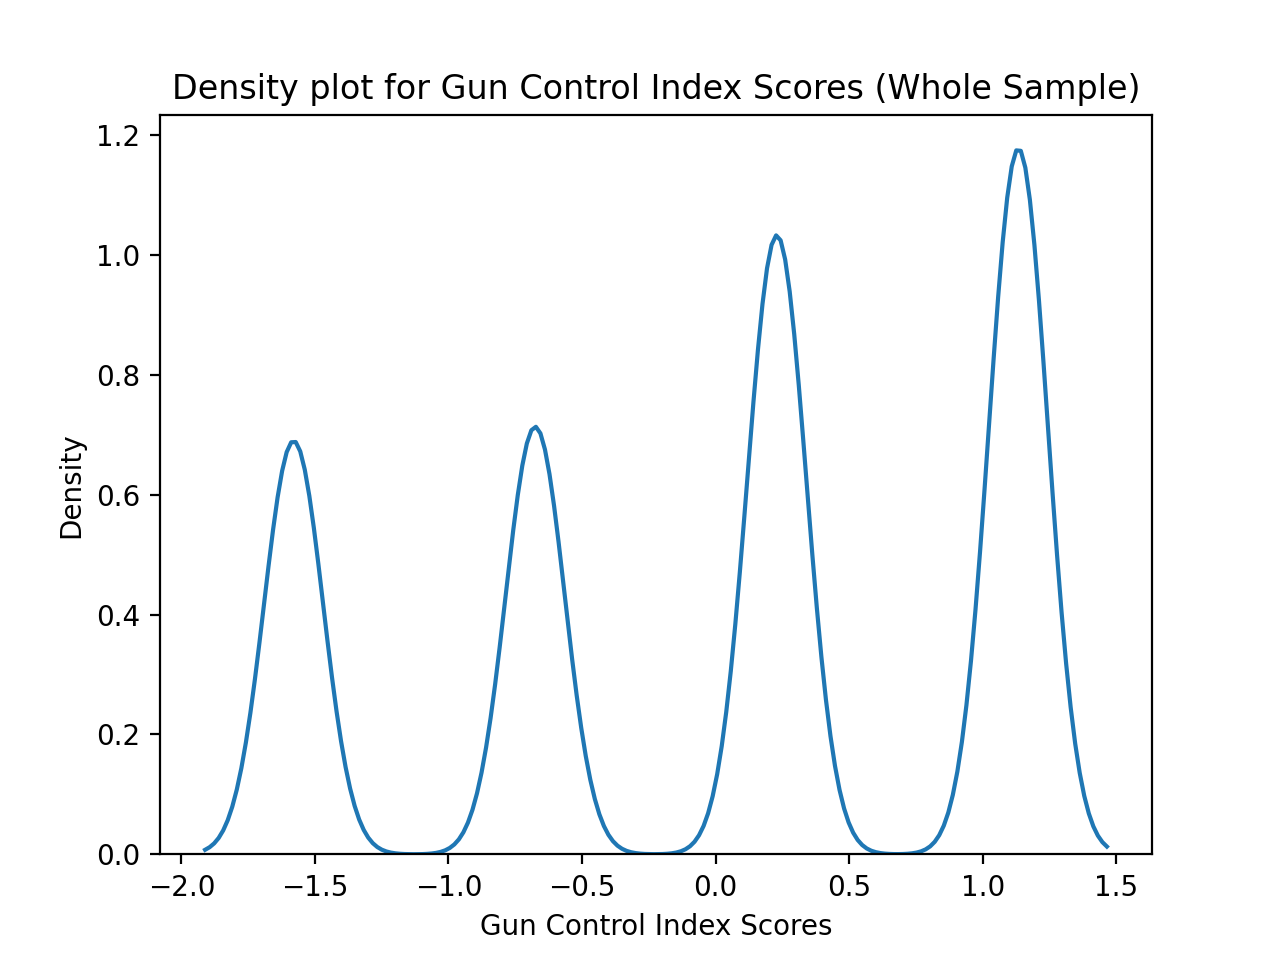

In [17]:
sns.kdeplot(election["gun_control_index"])
plt.title('Density plot for Gun Control Index Scores (Whole Sample)') 
plt.xlabel('Gun Control Index Scores')


fig2 = plt.gcf()
plt.show()
fig2.savefig('Fig2_Gun_control_density_plot_overall.pdf')

In [19]:
election_demrep = election[(election["pid3"] == 1) | (election["pid3"] == 2)].reset_index(drop = True)

election_demrep.value_counts(["pid3"])

pid3
1       22745
2       15224
Name: count, dtype: int64

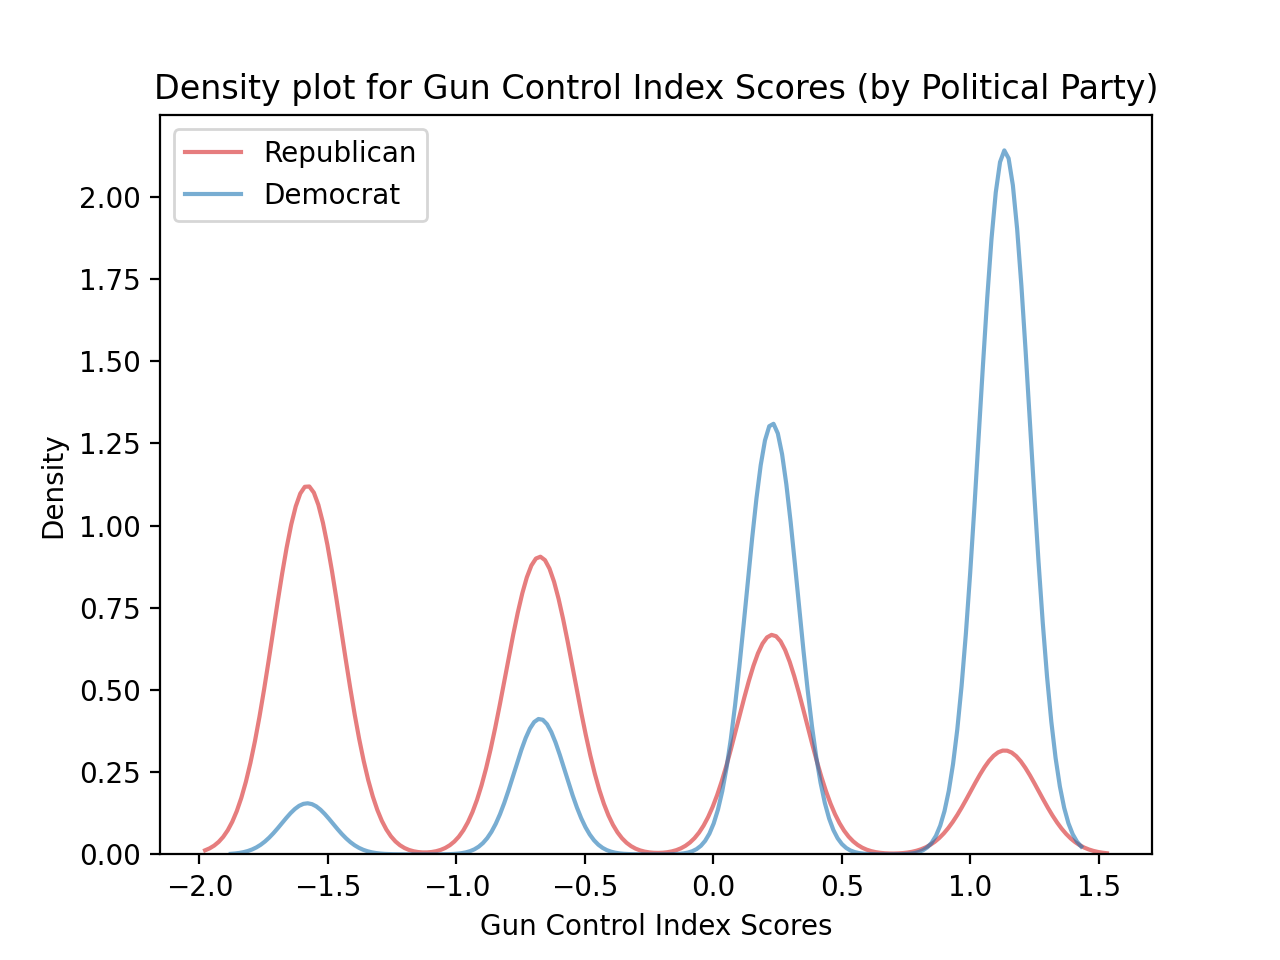

In [20]:
color = {1: "tab:blue", 2: "tab:red"}

sns.kdeplot(data=election_demrep, x="gun_control_index", hue="pid3", palette = color, common_norm=False, alpha=0.6)
plt.title('Density plot for Gun Control Index Scores (by Political Party)') 
plt.legend(["Republican", "Democrat"])
plt.xlabel('Gun Control Index Scores')

fig3 = plt.gcf()

plt.show()
fig2.savefig('Fig3_Gun_control_density_plot_by_Political_Party.pdf')